In [2]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score               # Na podstawie tego będziemy oceniali
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import xgboost as xgb

In [ ]:
df_contact = pd.read_csv('../data/contact_data_2000.csv')
df_train = pd.read_csv('../data/train_data_2000.csv')
df_test = pd.read_csv('../data/test_data_2000.csv')

# Oglądanie ramek

In [ ]:
df_train.tail()

,cellid,phase,order_within_phase,order
1496,SCG0093_GTCCAGGGTCAGGCAT-1,G2M,11,43
1497,SCG0090_GAGCATGCAAACGCGA-1,G2M,11,43
1498,SCG0092_GCTAGCCAGTTTCCGC-1,G2M,11,43
1499,SCG0092_TAGGGTTTCGCCTAAG-1,G2M,11,43
1500,SCG0088_AGTTGCAGTTAGCGTA-1,G2M,11,43


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1501 entries, 0 to 1500
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   cellid              1501 non-null   object
 1   phase               1501 non-null   object
 2   order_within_phase  1501 non-null   int64 
 3   order               1501 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 47.0+ KB


In [ ]:
df_test.head()

,cellid,phase,order_within_phase,order
0,SCG0089_CTTATGTTCCCGCCTA-1,NaN,NaN,NaN
1,SCG0093_AGAACCGCACAGCCAT-1,NaN,NaN,NaN
2,SCG0090_CCAGGATGTGCTCACC-1,NaN,NaN,NaN
3,SCG0089_TACCTTTAGCACTTGG-1,NaN,NaN,NaN
4,SCG0092_TGATCAGGTTTGAGGC-1,NaN,NaN,NaN


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cellid              380 non-null    object 
 1   phase               0 non-null      float64
 2   order_within_phase  0 non-null      float64
 3   order               0 non-null      float64
dtypes: float64(3), object(1)
memory usage: 12.0+ KB


In [ ]:
df_contact.head()

,chr1,start1,end1,chr2,start2,end2,cellid
0,chr13-M,74316813,74316959,chr13-M,72727004,72727154,SCG0088_TTTAACCTCAGCCAAT-1
1,chr1-M,79322530,79322563,chr12-M,4538118,4538268,SCG0088_TATAGGTGTCCCGGAA-1
2,chr2-M,75633331,75633491,chr8-P,125695812,125695962,SCG0088_CGTTAACAGTACCGCA-1
3,chr7-P,136324163,136324313,chr7-P,136352442,136352592,SCG0088_TTTAACCTCAGCCAAT-1
4,chr6-M,49253365,49253515,chr6-M,49323546,49323680,SCG0088_CGTTAACAGTACCGCA-1


In [ ]:
df_contact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732269 entries, 0 to 732268
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   chr1    732269 non-null  object
 1   start1  732269 non-null  int64 
 2   end1    732269 non-null  int64 
 3   chr2    732269 non-null  object
 4   start2  732269 non-null  int64 
 5   end2    732269 non-null  int64 
 6   cellid  732269 non-null  object
dtypes: int64(4), object(3)
memory usage: 39.1+ MB


In [ ]:
# Wszytskie komórki unikalne
df_train.iloc[:, 0].unique

<bound method Series.unique of 0       SCG0088_CTATGAGGTACCGGAT-1
1       SCG0088_GCTAAGCGTATTGGTG-1
2       SCG0089_TCCATTGTCTGTAAGC-1
3       SCG0092_GTTTATCTCATGCTAA-1
4       SCG0092_AACCGCTCAGCTCATA-1
                   ...            
1496    SCG0093_GTCCAGGGTCAGGCAT-1
1497    SCG0090_GAGCATGCAAACGCGA-1
1498    SCG0092_GCTAGCCAGTTTCCGC-1
1499    SCG0092_TAGGGTTTCGCCTAAG-1
1500    SCG0088_AGTTGCAGTTAGCGTA-1
Name: cellid, Length: 1501, dtype: object>

# Kod

## Contact count

In [ ]:
# Zliczenie ile razy komórka pojawiła się w tabeli df_contact
contacts_per_cell = df_contact.groupby("cellid").size()

In [ ]:
contacts_per_cell.head(10)

,0
cellid,
SCG008,1
SCG0088_AAAGGACGTTAACGGC-1,3854
SCG0088_AAATCCGGTGACATAT-1,2598
SCG0088_AACAGCAAGACAGGCG-1,2448
SCG0088_AACATCATCAGGTTTA-1,5753
SCG0088_AACTCACAGCTGAGGG-1,2217
SCG0088_ACAGGTAAGCTGTAAC-1,4249
SCG0088_ACGCTTGAGGCGGGTA-1,2407
SCG0088_ACGTCCTTCTGTGCCT-1,3644


In [ ]:
# Dodanie zliczonych kontaktów do train i test
df_train = df_train.merge(contacts_per_cell.rename("contact_count"), on="cellid", how="left")
df_test = df_test.merge(contacts_per_cell.rename("contact_count"), on="cellid", how="left")

## Procent udziału chromosomów

In [ ]:
# Procent udziału każdego chromosomu we wszystkich kontaktach każdej komórki

# Oddzielnie ch1 i ch2
contacts_per_chr1 = df_contact.groupby(["cellid", "chr1"]).size().unstack(fill_value=0)
contacts_per_chr2 = df_contact.groupby(["cellid", "chr2"]).size().unstack(fill_value=0)

# ch1 i ch2 razem
contacts_per_chr = contacts_per_chr1+contacts_per_chr2
percentage_contacts = contacts_per_chr.div(contacts_per_cell*2, axis=0) * 100
percentage_contacts

# Merge z train
df_train = df_train.merge(percentage_contacts, on='cellid', how='left')
# Merge z test
df_test = df_test.merge(percentage_contacts, on='cellid', how='left')

## Średnia odległość start-end

In [ ]:
# Średnie odległości start-stop
m_distance1 = df_contact['end1'] - df_contact['start1']
m_distance2 = df_contact['end2'] - df_contact['start2']

# To jest po prostu odległość dałam mean żeby się dobrze kolumna w train nazywała
df_contact['mean_distance'] = (m_distance1+m_distance2)/2
mean_distance_ch = df_contact.groupby(['cellid'])['mean_distance'].mean().reset_index()
# Merge z train
df_train = df_train.merge(mean_distance_ch, on='cellid', how='left')
# Merge z test
df_test = df_test.merge(mean_distance_ch, on='cellid', how='left')

## Średnia odległość z podziałem na cis i trans

In [ ]:
# Średnie odległości start-stop wewnątrz i międzychromosomowe

# Nowa klumna w df_contact mówiąca czy kontakt jest wewnątrzchromosomalny
df_contact['cis'] = np.where(df_contact['chr1']==df_contact['chr2'], 1, 0)
# Wektory ze średnimi
mean_distance_cis = df_contact[df_contact['cis']==1].groupby(['cellid', 'cis'])['mean_distance'].mean().reset_index()
mean_distance_trans = df_contact[df_contact['cis']==0].groupby(['cellid', 'cis'])['mean_distance'].mean().reset_index()
# Usuwam kolumnę cis
mean_distance_cis = mean_distance_cis.drop('cis', axis=1)
mean_distance_trans = mean_distance_trans.drop('cis', axis=1)
# Zmieniam nazwę kolumny żeby się nie duplikowała z 'mean_distance'
mean_distance_cis.columns = ['cellid', 'mean_distance_cis']
mean_distance_trans.columns = ['cellid', 'mean_distance_trans']
# Merge z train
df_train = df_train.merge(mean_distance_cis, on='cellid', how='left')
df_train = df_train.merge(mean_distance_trans, on='cellid', how='left')
# Merge z test
df_test = df_test.merge(mean_distance_cis, on='cellid', how='left')
df_test = df_test.merge(mean_distance_trans, on='cellid', how='left')

## to samo tylko mediana

In [ ]:
# Mediana odległości start-stop

median_distance_ch = df_contact.groupby(['cellid'])['mean_distance'].median().reset_index()
# Zmieniam nazwę żeby miało sens
median_distance_ch.rename(columns={'mean_distance': 'median_distance'}, inplace=True)
# Merge z train
df_train = df_train.merge(median_distance_ch, on='cellid', how='left')
# Merge z test
df_test = df_test.merge(median_distance_ch, on='cellid', how='left')

In [ ]:
# Mediana odległości start-stop wewnątrz i międzychromosomowe

# Wektory ze średnimi
median_distance_cis = df_contact[df_contact['cis']==1].groupby(['cellid', 'cis'])['mean_distance'].median().reset_index()
median_distance_trans = df_contact[df_contact['cis']==0].groupby(['cellid', 'cis'])['mean_distance'].median().reset_index()
# Usuwam kolumnę cis
median_distance_cis = median_distance_cis.drop('cis', axis=1)
median_distance_trans = median_distance_trans.drop('cis', axis=1)
# Zmieniam nazwę kolumny żeby się nie duplikowała z 'mean_distance'
median_distance_cis.columns = ['cellid', 'median_distance_cis']
median_distance_trans.columns = ['cellid', 'median_distance_trans']
# Merge z train
df_train = df_train.merge(median_distance_cis, on='cellid', how='left')
df_train = df_train.merge(median_distance_trans, on='cellid', how='left')
# Merge z test
df_test = df_test.merge(median_distance_cis, on='cellid', how='left')
df_test = df_test.merge(median_distance_trans, on='cellid', how='left')

In [ ]:
df_train

,cellid,phase,order_within_phase,order,contact_count,chr1-M,chr1-P,chr10-M,chr10-P,chr11-M,...,chr9-M,chr9-P,chrX-M,chrX-P,mean_distance,mean_distance_cis,mean_distance_trans,median_distance,median_distance_cis,median_distance_trans
0,SCG0088_CTATGAGGTACCGGAT-1,G1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SCG0088_GCTAAGCGTATTGGTG-1,G1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SCG0089_TCCATTGTCTGTAAGC-1,G1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SCG0092_GTTTATCTCATGCTAA-1,G1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SCG0092_AACCGCTCAGCTCATA-1,G1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1496,SCG0093_GTCCAGGGTCAGGCAT-1,G2M,11,43,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1497,SCG0090_GAGCATGCAAACGCGA-1,G2M,11,43,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1498,SCG0092_GCTAGCCAGTTTCCGC-1,G2M,11,43,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1499,SCG0092_TAGGGTTTCGCCTAAG-1,G2M,11,43,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Procent kontaktów wewnątrzchromosomalnych

In [ ]:
# Procent kontaktów wewnątrzchromosomalnych
# Zliczenie tych i tych
cisAndTrans = df_contact.groupby(['cellid', 'cis']).size().unstack(fill_value=0)
cisAndTrans

cis,0,1
cellid,,
SCG008,0,1
SCG0088_AAAGGACGTTAACGGC-1,675,3179
SCG0088_AAATCCGGTGACATAT-1,302,2296
SCG0088_AACAGCAAGACAGGCG-1,283,2165
SCG0088_AACATCATCAGGTTTA-1,525,5228
...,...,...
SCG0093_TTGTCCATCACAGGAA-1,321,1764
SCG0093_TTTAGCAAGTAACTCA-1,382,2377
SCG0093_TTTCCGGGTTAGGCTA-1,307,1836


In [ ]:
# Obliczenie udziału cis
cisAndTrans['cis%'] = cisAndTrans[1]/(cisAndTrans[1]+cisAndTrans[0])
# Zostawiam tylko kolumnę z procentem
cisAndTrans = cisAndTrans.drop(columns=[0, 1], axis=1)
# Merge z train
df_train = df_train.merge(cisAndTrans, on='cellid', how='left')
# Merge z test
df_test = df_test.merge(cisAndTrans, on='cellid', how='left')

## Najbardziej aktywny region (ze 100)

In [ ]:
# Który region najbardziej aktywny
print("min start1: " + str(df_contact['start1'].min()))
print('max end1: ' + str(df_contact['end1'].max()))
print('min start2: ' + str(df_contact['start2'].min()))
print('max end2: ' + str(df_contact['end2'].max()))

# Dziele cały 'zasięg' na 100 części
region_width = (df_contact['end1'].max()-df_contact['start2'].min() )/100
print(region_width)
region_start = df_contact['start2'].min()

# Środek przedziału
df_contact['midpoint1'] = (df_contact['end1'] + df_contact['start1'])/2
df_contact['midpoint2'] = (df_contact['end2'] + df_contact['start2'])/2
# Region
df_contact['region1'] = np.floor((df_contact['midpoint1'] - region_start)/region_width)
df_contact['region2'] = np.floor((df_contact['midpoint2'] - region_start)/region_width)

min start1: 3003355
max end1: 195370072
min start2: 3001393
max end2: 195371528
1923686.79


In [ ]:
df_regions = df_contact[['cellid', 'region1', 'region2']]
# Jak pivot longer
df_long = df_regions.melt(id_vars=['cellid'], value_vars=['region1', 'region2'], value_name = 'median_region', var_name = 'type').drop('type', axis=1)
# Obliczam medianę
median_region = df_long.groupby(['cellid'])['median_region'].median()
# Merge z train
df_train = df_train.merge(median_region, on='cellid', how='left')
# Merge z test
df_test = df_test.merge(median_region, on='cellid', how='left')

# Podzielić na chromosomy

In [ ]:
df_train

,cellid,phase,order_within_phase,order,contact_count,chr1-M,chr1-P,chr10-M,chr10-P,chr11-M,...,chrX-M,chrX-P,mean_distance,mean_distance_cis,mean_distance_trans,median_distance,median_distance_cis,median_distance_trans,cis%,median_region
0,SCG0088_CTATGAGGTACCGGAT-1,G1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SCG0088_GCTAAGCGTATTGGTG-1,G1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SCG0089_TCCATTGTCTGTAAGC-1,G1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SCG0092_GTTTATCTCATGCTAA-1,G1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SCG0092_AACCGCTCAGCTCATA-1,G1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1496,SCG0093_GTCCAGGGTCAGGCAT-1,G2M,11,43,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1497,SCG0090_GAGCATGCAAACGCGA-1,G2M,11,43,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1498,SCG0092_GCTAGCCAGTTTCCGC-1,G2M,11,43,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1499,SCG0092_TAGGGTTTCGCCTAAG-1,G2M,11,43,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Procent bliskich i dalekich kontaktów

In [ ]:
# Wykres odległości kontaktów
# Raczej start1 start2 a nie start1 end1

df_contact.head()
distance1 = df_contact['end1']-df_contact['start1']
distance2 = df_contact['end2']-df_contact['start2']

(array([1.78410611e-02, 1.48241058e-02, 8.84128222e-03, 6.18957683e-03,
        3.90000795e-03, 2.34589179e-03, 1.93592325e-03, 1.57109795e-03,
        1.34156085e-03, 1.52708682e-03, 2.12541164e-03, 2.37476082e-03,
        4.28096595e-03, 3.34859531e-02, 8.08615894e-04, 1.67978136e-04,
        4.75489920e-05, 1.11796737e-05, 5.80210915e-06, 1.13211886e-06]),
 array([ 18.  ,  27.65,  37.3 ,  46.95,  56.6 ,  66.25,  75.9 ,  85.55,
         95.2 , 104.85, 114.5 , 124.15, 133.8 , 143.45, 153.1 , 162.75,
        172.4 , 182.05, 191.7 , 201.35, 211.  ]),
 <BarContainer object of 20 artists>)

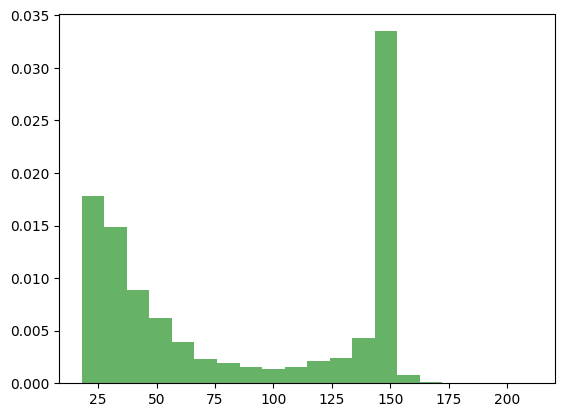

In [ ]:
plt.hist(distance1, bins=20, density=True, alpha=0.6, color='g')

(array([5.48704090e-03, 6.54632156e-03, 5.37655619e-03, 4.00380092e-03,
        2.90348308e-03, 2.17222532e-03, 1.88606308e-03, 1.76583377e-03,
        1.94068782e-03, 2.03017356e-03, 2.90663979e-03, 4.14914664e-03,
        7.66928533e-03, 5.08493148e-02, 6.04440534e-04, 1.50835637e-04,
        4.46056252e-05, 1.27640712e-05, 2.60771348e-06, 6.86240388e-07]),
 array([ 18.  ,  27.95,  37.9 ,  47.85,  57.8 ,  67.75,  77.7 ,  87.65,
         97.6 , 107.55, 117.5 , 127.45, 137.4 , 147.35, 157.3 , 167.25,
        177.2 , 187.15, 197.1 , 207.05, 217.  ]),
 <BarContainer object of 20 artists>)

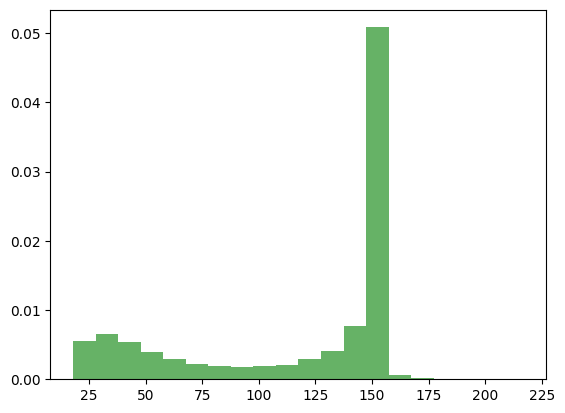

In [ ]:
plt.hist(distance2, bins=20, density=True, alpha=0.6, color='g')

In [ ]:
single_cell_df = df_contact[df_contact['cellid']=='SCG0089_CTTATGTTCCCGCCTA-1']
single_cell_distance1 = single_cell_df['end2']-single_cell_df['start2']

/usr/local/lib/python3.11/dist-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

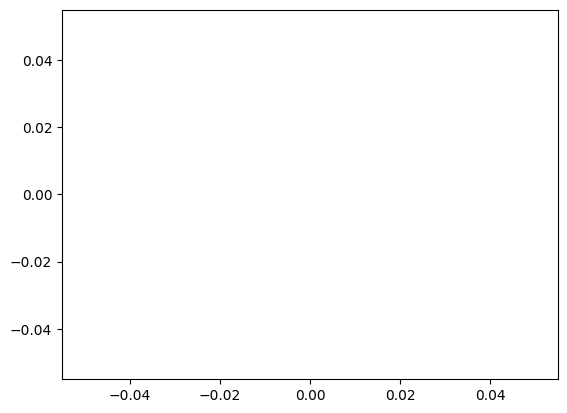

In [ ]:
plt.hist(single_cell_distance1, bins=20, density=True, alpha=0.6, color='g')

In [ ]:
df_contact

,chr1,start1,end1,chr2,start2,end2,cellid,mean_distance,cis,midpoint1,midpoint2,region1,region2
0,chr13-M,74316813,74316959,chr13-M,72727004,72727154,SCG0088_TTTAACCTCAGCCAAT-1,148.0,1,74316886.0,72727079.0,37.0,36.0
1,chr1-M,79322530,79322563,chr12-M,4538118,4538268,SCG0088_TATAGGTGTCCCGGAA-1,91.5,0,79322546.5,4538193.0,39.0,0.0
2,chr2-M,75633331,75633491,chr8-P,125695812,125695962,SCG0088_CGTTAACAGTACCGCA-1,155.0,0,75633411.0,125695887.0,37.0,63.0
3,chr7-P,136324163,136324313,chr7-P,136352442,136352592,SCG0088_TTTAACCTCAGCCAAT-1,150.0,1,136324238.0,136352517.0,69.0,69.0
4,chr6-M,49253365,49253515,chr6-M,49323546,49323680,SCG0088_CGTTAACAGTACCGCA-1,142.0,1,49253440.0,49323613.0,24.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
732264,chr13-P,94413286,94413320,chr2-P,91683153,91683294,SCG0088_AGGTCTTAGGGCCATC-1,87.5,0,94413303.0,91683223.5,47.0,46.0
732265,chr3-P,56838564,56838602,chr3-P,56838406,56838556,SCG0088_AGGTCTTAGGGCCATC-1,94.0,1,56838583.0,56838481.0,27.0,27.0
732266,chr4-M,77885855,77885895,chr4-M,77884749,77884899,SCG0088_GCTGAGGAGGATCACT-1,95.0,1,77885875.0,77884824.0,38.0,38.0
732267,chr10-P,59710909,59710931,chr10-P,59487488,59487638,SCG0088_ACTTATCTCGGTCAGC-1,86.0,1,59710920.0,59487563.0,29.0,29.0


In [ ]:
# Uznaje kontakty < 50 za bliskie i > 125 za dalekie
df_contact['distance1'] = df_contact['end1']-df_contact['start1']
df_contact['distance2'] = df_contact['end2']-df_contact['start2']

bins = [0, 50, 125, 180]
labels = ['Close', 'Medium', 'Far']

df_contact['category1'] = pd.cut(df_contact['distance1'], bins=bins, labels=labels, right=False)
df_contact['category2'] = pd.cut(df_contact['distance2'], bins=bins, labels=labels, right=False)
df_contact
# Widać że średnia z obu odległośic była słabym pomysłem bo potrafią bardzo się różnić

,chr1,start1,end1,chr2,start2,end2,cellid,mean_distance,cis,midpoint1,midpoint2,region1,region2,distance1,distance2,category1,category2
0,chr13-M,74316813,74316959,chr13-M,72727004,72727154,SCG0088_TTTAACCTCAGCCAAT-1,148.0,1,74316886.0,72727079.0,37.0,36.0,146,150,Far,Far
1,chr1-M,79322530,79322563,chr12-M,4538118,4538268,SCG0088_TATAGGTGTCCCGGAA-1,91.5,0,79322546.5,4538193.0,39.0,0.0,33,150,Close,Far
2,chr2-M,75633331,75633491,chr8-P,125695812,125695962,SCG0088_CGTTAACAGTACCGCA-1,155.0,0,75633411.0,125695887.0,37.0,63.0,160,150,Far,Far
3,chr7-P,136324163,136324313,chr7-P,136352442,136352592,SCG0088_TTTAACCTCAGCCAAT-1,150.0,1,136324238.0,136352517.0,69.0,69.0,150,150,Far,Far
4,chr6-M,49253365,49253515,chr6-M,49323546,49323680,SCG0088_CGTTAACAGTACCGCA-1,142.0,1,49253440.0,49323613.0,24.0,24.0,150,134,Far,Far
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732264,chr13-P,94413286,94413320,chr2-P,91683153,91683294,SCG0088_AGGTCTTAGGGCCATC-1,87.5,0,94413303.0,91683223.5,47.0,46.0,34,141,Close,Far
732265,chr3-P,56838564,56838602,chr3-P,56838406,56838556,SCG0088_AGGTCTTAGGGCCATC-1,94.0,1,56838583.0,56838481.0,27.0,27.0,38,150,Close,Far
732266,chr4-M,77885855,77885895,chr4-M,77884749,77884899,SCG0088_GCTGAGGAGGATCACT-1,95.0,1,77885875.0,77884824.0,38.0,38.0,40,150,Close,Far
732267,chr10-P,59710909,59710931,chr10-P,59487488,59487638,SCG0088_ACTTATCTCGGTCAGC-1,86.0,1,59710920.0,59487563.0,29.0,29.0,22,150,Close,Far


In [ ]:
# Procent bliskich i dalekich kontaktów
# Zliczenie tych i tych
closeAndFar1 = df_contact.groupby(['cellid', 'category1'], observed=False).size().unstack(fill_value=0)
closeAndFar2 = df_contact.groupby(['cellid', 'category2'], observed=False).size().unstack(fill_value=0)

closeAndFar = closeAndFar1+closeAndFar2
closeAndFar

category1,Close,Medium,Far
cellid,,,
SCG008,1,0,1
SCG0088_AAAGGACGTTAACGGC-1,2191,1375,4138
SCG0088_AAATCCGGTGACATAT-1,1701,1001,2494
SCG0088_AACAGCAAGACAGGCG-1,1619,755,2520
SCG0088_AACATCATCAGGTTTA-1,3469,1832,6202
...,...,...,...
SCG0093_TTGTCCATCACAGGAA-1,1333,884,1952
SCG0093_TTTAGCAAGTAACTCA-1,1743,921,2853
SCG0093_TTTCCGGGTTAGGCTA-1,1365,846,2071


In [ ]:
# Obliczenie udziału
sum = closeAndFar['Close']+closeAndFar['Medium']+closeAndFar['Far']
closeAndFar['close%'] = closeAndFar['Close']/sum
closeAndFar['far%'] = closeAndFar['Far']/sum

# Zostawiam tylko kolumnę z procentem
closeAndFar = closeAndFar.drop(columns=['Close', 'Far', 'Medium'], axis=1)
# Merge z train
df_train = df_train.merge(closeAndFar, on='cellid', how='left')
# Merge z test
df_test = df_test.merge(closeAndFar, on='cellid', how='left')

<Axes: >

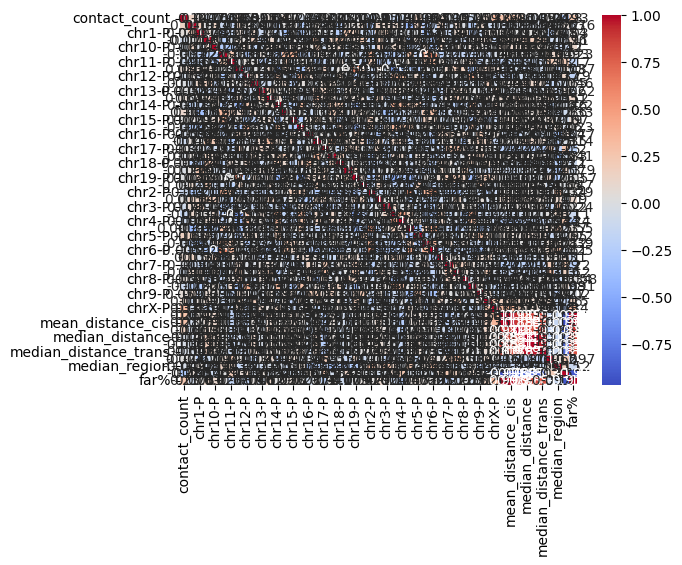

In [ ]:
df_train_corr = df_train.drop(['cellid', 'phase', 'order_within_phase', 'order'], axis=1)
sns.heatmap(df_train_corr.corr(), annot=True, cmap="coolwarm")

<Axes: >

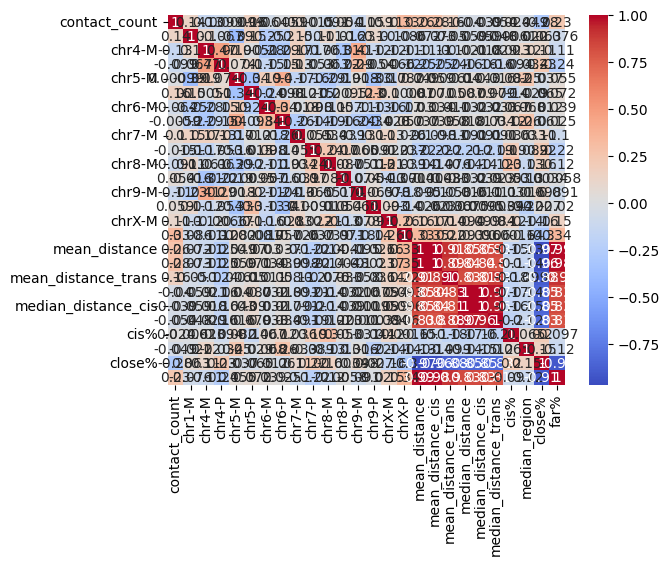

In [ ]:
df_train_corr2 = df_train_corr.drop(df_train_corr.columns[2:27], axis=1)
sns.heatmap(df_train_corr2.corr(), annot=True, cmap="coolwarm")

In [ ]:
df_train

,cellid,phase,order_within_phase,order,contact_count,chr1-M,chr1-P,chr10-M,chr10-P,chr11-M,...,mean_distance,mean_distance_cis,mean_distance_trans,median_distance,median_distance_cis,median_distance_trans,cis%,median_region,close%,far%
0,SCG0088_CTATGAGGTACCGGAT-1,G1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SCG0088_GCTAAGCGTATTGGTG-1,G1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SCG0089_TCCATTGTCTGTAAGC-1,G1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SCG0092_GTTTATCTCATGCTAA-1,G1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SCG0092_AACCGCTCAGCTCATA-1,G1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1496,SCG0093_GTCCAGGGTCAGGCAT-1,G2M,11,43,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1497,SCG0090_GAGCATGCAAACGCGA-1,G2M,11,43,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1498,SCG0092_GCTAGCCAGTTTCCGC-1,G2M,11,43,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1499,SCG0092_TAGGGTTTCGCCTAAG-1,G2M,11,43,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Testowanie

In [ ]:
# Dzielę train na 2 i nie ruszam test
y = df_train['phase']
x = df_train.drop(['cellid', 'phase', 'order_within_phase', 'order'], axis = 1)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 0, stratify = y)

In [ ]:
#scaler = StandardScaler()
#x_train = scaler.fit_transform(x_train)
#x_val = scaler.transform(x_test)

In [ ]:
# SVM
svm_model = SVC(kernel = 'rbf', random_state = 42)
svm_model.fit(x_train, y_train)

y_pred_svm = svm_model.predict(x_val)
print(y_pred_svm)
print("Accuracy:", accuracy_score(y_val, y_pred_svm))

ValueError: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# Random forest
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_model.fit(x_train, y_train)
y_pred_rf = rf_model.predict(x_val)
accuracy_score(y_val, y_pred_rf)

0.6212624584717608

In [ ]:
# Logistic regresion
lr_model = LogisticRegression(random_state = 42, max_iter = 10000)
lr_model.fit(x_train, y_train)
y_pred_lr = lr_model.predict(x_val)
print("Accuracy:", accuracy_score(y_val, y_pred_lr))

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# XGBoost

le = LabelEncoder()
y_numeric_train = le.fit_transform(y_train)  # Zamienia 'G1' -> 0 itd
y_numeric_val = le.fit_transform(y_val)

xgb_model = xgb.XGBClassifier(random_state = 42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(x_train, y_numeric_train)

y_pred_xgb = xgb_model.predict(x_val)
print("Accuracy:", accuracy_score(y_numeric_val, y_pred_xgb))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:31:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.6146179401993356


In [ ]:
df_train.head()

,cellid,phase,order_within_phase,order,contact_count,chr1-M,chr1-P,chr10-M,chr10-P,chr11-M,...,mean_distance,mean_distance_cis,mean_distance_trans,median_distance,median_distance_cis,median_distance_trans,cis%,median_region,close%,far%
0,SCG0088_CTATGAGGTACCGGAT-1,G1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SCG0088_GCTAAGCGTATTGGTG-1,G1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SCG0089_TCCATTGTCTGTAAGC-1,G1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SCG0092_GTTTATCTCATGCTAA-1,G1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SCG0092_AACCGCTCAGCTCATA-1,G1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_test.head()

,cellid,phase,order_within_phase,order,contact_count,chr1-M,chr1-P,chr10-M,chr10-P,chr11-M,...,mean_distance,mean_distance_cis,mean_distance_trans,median_distance,median_distance_cis,median_distance_trans,cis%,median_region,close%,far%
0,SCG0089_CTTATGTTCCCGCCTA-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SCG0093_AGAACCGCACAGCCAT-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SCG0090_CCAGGATGTGCTCACC-1,NaN,NaN,NaN,6781.0,3.649904,6.835275,4.173426,3.148503,2.543873,...,101.571302,101.354809,102.482335,98.0,98.0,99.75,0.807993,33.0,0.229861,0.46378
3,SCG0089_TACCTTTAGCACTTGG-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SCG0092_TGATCAGGTTTGAGGC-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_train.to_csv('data_with_features/train_with_features.csv', index=False)

In [ ]:
df_test.to_csv('data_with_features/test_with_features.csv', index=False)